In [1]:
!pip install autorom[accept-rom-license]
!AutoROM --install-dir /ROMS -y

!pip install stable-baselines3[extra]
# !pip install wandb

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/ROMS

Existing ROMs will be overwritten.


In [2]:
from stable_baselines3 import A2C, PPO, DQN, DDPG, HER
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
env_id = "Frostbite"
env_name = env_id + "NoFrameskip-v4"
model_constructor = A2C
model_class_name = "A2C"
difficulty = 0

hyperparameters = {
    'policy': "CnnPolicy",
    'frame_stack': 4,
    'n_envs': 16,
    'n_timesteps': 20_000_000,
    'seed': 1,
    'activation_fn': 'tanh',
    'normalize': False,
    'buffer_size': 1000000
}

# DQN_optimized_params = {
#     'gamma': 0.99,
#     'learning_rate': 5.77145931515998e-05,
#     'batch_size': 100,
#     'buffer_size': 100000,
#     'exploration_final_eps': 0.04048683465451819,
#     'exploration_fraction': 0.3809583517439022,
#     'target_update_interval': 5000,
#     'learning_starts': 0,
#     'train_freq': 128,
#     # 'policy_kwargs': {
#     #     'net_arch': 'tiny'
#     #  },
#     # 'subsample_steps': 2
# }

# DQN_policy_params = {
#     'net_arch': 'tiny'
# }

experiment_version = f"{model_class_name}_{hyperparameters['policy']}_{hyperparameters['frame_stack']}-FrameStack_Seed{hyperparameters['seed']}_V12"
tensorflow_path = "/tf_logs/"
models_path = f"/models/{timestr}_{env_name}_{experiment_version}"
gifs_path = models_path + "/gifs/"
videos_path = models_path + "/videos/"
best_models_path = models_path + f"_best/"

print(timestr)

import os

monitor_path = f"{tensorflow_path}{timestr}_{env_name}_{experiment_version}_monitor/"
os.makedirs(monitor_path, exist_ok=True)

save_freq = max(100_000 // hyperparameters["n_envs"], 1)
video_record_frequency = lambda x: x % save_freq*5 == 0
checkpoint_callback_name_prefix=f"{env_name}_{timestr}"

from stable_baselines3.common.env_util import make_atari_env
vec_env = make_atari_env(env_name, n_envs=hyperparameters["n_envs"], seed=hyperparameters["seed"])

print(f"Models path: {models_path}")
print(f"Gifs path: {gifs_path}")
print(f"Videos path: {videos_path}")
print(f"The best model path: {best_models_path}")

20240329-170115
Models path: /models/20240329-170115_FrostbiteNoFrameskip-v4_A2C_CnnPolicy_4-FrameStack_Seed1_V12
Gifs path: /models/20240329-170115_FrostbiteNoFrameskip-v4_A2C_CnnPolicy_4-FrameStack_Seed1_V12/gifs/
Videos path: /models/20240329-170115_FrostbiteNoFrameskip-v4_A2C_CnnPolicy_4-FrameStack_Seed1_V12/videos/
The best model path: /models/20240329-170115_FrostbiteNoFrameskip-v4_A2C_CnnPolicy_4-FrameStack_Seed1_V12_best/


In [3]:
#Benchmark hardware
def benchmark(model_constructor, policy, vec_env, device):
  model = model_constructor(policy, vec_env, verbose=0, device=device)
  start_time = time.time()
  model_class_name = type(model).__name__
  model.learn(total_timesteps=10_000)
  print(f"Time {model_class_name}-{policy} with {model.device}: {time.time()-start_time:.2f}s")

benchmark(PPO, "MlpPolicy", vec_env, "cuda")
benchmark(PPO, "MlpPolicy", vec_env, "cpu")
benchmark(PPO, "CnnPolicy", vec_env, "cuda")
benchmark(PPO, "CnnPolicy", vec_env, "cpu")
benchmark(DQN, "MlpPolicy", vec_env, "cuda")
benchmark(DQN, "MlpPolicy", vec_env, "cpu")
benchmark(A2C, "CnnPolicy", vec_env, "cuda")
benchmark(A2C, "CnnPolicy", vec_env, "cpu")

vec_env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Time PPO-MlpPolicy with cuda: 25.78s
Time PPO-MlpPolicy with cpu: 30.48s
Time PPO-CnnPolicy with cuda: 26.45s
Time PPO-CnnPolicy with cpu: 86.99s
Time DQN-MlpPolicy with cuda: 4.19s
Time DQN-MlpPolicy with cpu: 4.25s
Time A2C-CnnPolicy with cuda: 5.34s
Time A2C-CnnPolicy with cpu: 59.24s


In [4]:
!pip install --quiet optuna

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# import wandb
# run = wandb.init(
#     project=experiment_version,
#     config=hyperparameters,
#     sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
#     monitor_gym=True,  # auto-upload the videos of agents playing the game
#     save_code=True,  # optional
# )

In [6]:
import imageio
import numpy as np
from stable_baselines3.common.logger import TensorBoardOutputFormat
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.vec_env.vec_video_recorder import VecVideoRecorder

# from wandb.integration.sb3 import WandbCallback

def save_model(model, path):
  model.save(path)
  del model
  env = make_atari_env(env_name, n_envs=hyperparameters["n_envs"], seed=hyperparameters["seed"], monitor_dir=monitor_path)
  env = VecFrameStack(env, n_stack=hyperparameters["frame_stack"])
  model = model_constructor.load(path, env)
  return model

def load_model(path):
  env = make_atari_env(env_name, n_envs=hyperparameters["n_envs"], seed=hyperparameters["seed"], monitor_dir=monitor_path)
  env = VecFrameStack(env, n_stack=hyperparameters["frame_stack"])
  model = model_constructor.load(path, env)
  return model

def create_vec_env_with_difficulty(difficulty):
  vec_env = make_atari_env(env_name, n_envs=hyperparameters["n_envs"], seed=hyperparameters["seed"], monitor_dir=monitor_path, env_kwargs=dict(difficulty=difficulty))
  vec_env = VecFrameStack(vec_env, n_stack=hyperparameters["frame_stack"])
  # vec_env = VecVideoRecorder(
  #   vec_env,
  #   f"{videos_path}",
  #   record_video_trigger=video_record_frequency,
  #   video_length=5000,
  # )
  return vec_env

def load_model_with_difficulty(path, difficulty):
  vec_env = create_vec_env_with_difficulty(difficulty)
  model = model_constructor.load(path, vec_env)
  return model

def create_model_with_difficulty(model_constructor, difficulty):
  vec_env = create_vec_env_with_difficulty(difficulty)
  # kwargs = DQN_optimized_params
  # policy_kwargs = DQN_policy_params
  # policy = ActorCriticPolicy(net_arch=hyperparameters['net_arch'], activation_fn=hyperparameters['activation_fn'])
  model = model_constructor(hyperparameters["policy"],
              vec_env,
              verbose=0,
              tensorboard_log=tensorflow_path + file_name,
              # policy_kwargs=policy_kwargs,
              # **kwargs
                            )
  return model

def model_to_images(model, gif_name):
  images = []
  obs = model.env.reset()
  img = model.env.render(mode="rgb_array")
  for i in range(1500):
      images.append(img)
      action, _ = model.predict(obs)
      obs, _, _ ,_ = model.env.step(action)
      img = model.env.render(mode="rgb_array")

  imageio.mimsave(gif_name, [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
  return images

%matplotlib inline
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    plt.close(anim._fig)
    display(HTML(anim.to_jshtml()))

def replay_human(model, vec_env):
  while True:
      action, _states = model.predict(obs, deterministic=False)
      obs, rewards, dones, info = vec_env.step(action)
      vec_env.render("human")

def generate_file_name(steps):
  return f"{timestr}_{env_id}_{experiment_version}_{model_class_name}_{steps}"

def create_callback(difficulty):
  checkpoint_callback = CheckpointCallback(
    save_freq=save_freq,
    save_path=models_path,
    name_prefix=checkpoint_callback_name_prefix,
    save_replay_buffer=False,
    save_vecnormalize=False,
    verbose=True
  )

  eval_env = create_vec_env_with_difficulty(difficulty)

  eval_callback = EvalCallback(eval_env, best_model_save_path=best_models_path,
                              log_path=monitor_path, eval_freq=save_freq/2,
                              deterministic=True, render=True)

  # wandb_callback = WandbCallback(verbose=2)

  # callback = CallbackList([checkpoint_callback, eval_callback, wandb_callback])
  callback = CallbackList([checkpoint_callback, eval_callback])
  return callback

In [7]:
import time
import threading
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.policies import ActorCriticPolicy

file_name = generate_file_name(hyperparameters["n_timesteps"])

def initiate_learn(model_constructor, steps, difficulty, index):
  start_time = time.time()
  model = create_model_with_difficulty(model_constructor, difficulty)
  tb_log_name = f"initial_{index}_{steps}"
  model.learn(total_timesteps=steps, tb_log_name=tb_log_name, callback=create_callback(difficulty))

  print(f"Time {model_class_name} with {model.device} : {time.time()-start_time:.2f}s")

  obs = vec_env.reset()
  return model

def continue_learn(model, steps, difficulty, index):
  model_class_name = type(model).__name__
  file_name = generate_file_name(steps)
  start_time = time.time()
  tb_log_name = f"continue_{index}_{steps}"
  model.learn(total_timesteps=steps, tb_log_name=tb_log_name, reset_num_timesteps=False, callback=create_callback(difficulty))

  print(f"Time {model_class_name} with {model.device} : {time.time()-start_time:.2f}s")

  obs = vec_env.reset()
  return model

In [8]:
# import gymnasium
# import optuna
# from optuna.pruners import MedianPruner
# from optuna.samplers import TPESampler
# from typing import Any
# from typing import Dict
# import torch
# import torch.nn as nn

# N_TRIALS = 100
# N_STARTUP_TRIALS = 5
# N_EVALUATIONS = 2
# N_TIMESTEPS = int(2e4)
# EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
# N_EVAL_EPISODES = 3
# ENV_ID = env_name

# DEFAULT_HYPERPARAMS = {
#     "policy": "MlpPolicy",
#     "env": ENV_ID,
# }

# def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
#     """Sampler for A2C hyperparameters."""
#     gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
#     max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
#     gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.001, 0.2, log=True)
#     n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
#     learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
#     ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
#     ortho_init = trial.suggest_categorical("ortho_init", [False, True])
#     net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
#     activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])

#     # Display true values.
#     trial.set_user_attr("gamma_", gamma)
#     trial.set_user_attr("gae_lambda_", gae_lambda)
#     trial.set_user_attr("n_steps", n_steps)

#     net_arch = [
#         {"pi": [64], "vf": [64]} if net_arch == "tiny" else {"pi": [64, 64], "vf": [64, 64]}
#     ]

#     activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

#     return {
#         "n_steps": n_steps,
#         "gamma": gamma,
#         "gae_lambda": gae_lambda,
#         "learning_rate": learning_rate,
#         "ent_coef": ent_coef,
#         "max_grad_norm": max_grad_norm,
#         "policy_kwargs": {
#             "net_arch": net_arch,
#             "activation_fn": activation_fn,
#             "ortho_init": ortho_init,
#         },
#     }

# class TrialEvalCallback(EvalCallback):
#     """Callback used for evaluating and reporting a trial."""

#     def __init__(
#         self,
#         eval_env: gymnasium.Env,
#         trial: optuna.Trial,
#         n_eval_episodes: int = 5,
#         eval_freq: int = 10000,
#         deterministic: bool = True,
#         verbose: int = 0,
#     ):
#         super().__init__(
#             eval_env=eval_env,
#             n_eval_episodes=n_eval_episodes,
#             eval_freq=eval_freq,
#             deterministic=deterministic,
#             verbose=verbose,
#         )
#         self.trial = trial
#         self.eval_idx = 0
#         self.is_pruned = False

#     def _on_step(self) -> bool:
#         if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
#             super()._on_step()
#             self.eval_idx += 1
#             self.trial.report(self.last_mean_reward, self.eval_idx)
#             # Prune trial if need.
#             if self.trial.should_prune():
#                 self.is_pruned = True
#                 return False
#         return True

# def objective(trial):
#     # iris = sklearn.datasets.load_iris()

#     # n_estimators = trial.suggest_int("n_estimators", 2, 20)
#     # max_depth = int(trial.suggest_float("max_depth", 1, 32, log=True))

#     # clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

#     # return sklearn.model_selection.cross_val_score(
#     #     clf, iris.data, iris.target, n_jobs=-1, cv=3
#     # ).mean()
#     kwargs = DEFAULT_HYPERPARAMS.copy()
#     # Sample hyperparameters.
#     kwargs.update(sample_a2c_params(trial))
#     # Create the RL model.
#     model = A2C(**kwargs)
#     # Create env used for evaluation.
#     eval_env = Monitor(gymnasium.make(ENV_ID))
#     # Create the callback that will periodically evaluate and report the performance.
#     eval_callback = TrialEvalCallback(
#         eval_env, trial, n_eval_episodes=N_EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
#     )

#     nan_encountered = False
#     try:
#         model.learn(N_TIMESTEPS, callback=eval_callback)
#     except AssertionError as e:
#         # Sometimes, random hyperparams can generate NaN.
#         print(e)
#         nan_encountered = True
#     finally:
#         # Free memory.
#         model.env.close()
#         eval_env.close()

#     # Tell the optimizer that the trial failed.
#     if nan_encountered:
#         return float("nan")

#     if eval_callback.is_pruned:
#         raise optuna.exceptions.TrialPruned()

#     return eval_callback.last_mean_reward


# # study = optuna.create_study(direction="maximize")
# # study.optimize(objective, n_trials=100)

# # trial = study.best_trial

# # print("Accuracy: {}".format(trial.value))
# # print("Best hyperparameters: {}".format(trial.params))
# # Set pytorch num threads to 1 for faster training.
# torch.set_num_threads(1)

# sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# # Do not prune before 1/3 of the max budget is used.
# pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3)

# study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
# try:
#     study.optimize(objective, n_trials=N_TRIALS, timeout=600)
# except KeyboardInterrupt:
#     pass

# print("Number of finished trials: ", len(study.trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# print("  User attrs:")
# for key, value in trial.user_attrs.items():
#     print("    {}: {}".format(key, value))

In [9]:
steps = hyperparameters["n_timesteps"]
model = initiate_learn(model_constructor, steps, difficulty, 0)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x79e279315780> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x79e27935a170>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Eval num_timesteps=50000, episode_reward=0.00 +/- 0.00
Episode length: 108000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=100000, episode_reward=160.00 +/- 0.00
Episode length: 4003.00 +/- 0.00
New best mean reward!
Eval num_timesteps=150000, episode_reward=160.00 +/- 0.00
Episode length: 4002.00 +/- 0.00
Eval num_timesteps=200000, episode_reward=160.00 +/- 0.00
Episode length: 4003.00 +/- 0.00
Eval num_timesteps=250000, episode_reward=166.00 +/- 20.59
Episode length: 2303.80 +/- 953.49
New best mean reward!
Eval num_timesteps=300000, episode_reward=192.00 +/- 16.00
Episode length: 3111.40 +/- 556.44
New best mean reward!
Eval num_timesteps=350000, episode_reward=194.00 +/- 17.44
Episode length: 3288.20 +/- 883.81
New best mean reward!
Eval num_timesteps=400000, episode_reward=222.00 +/- 29.26
Episode length: 2344.60 +/- 376.77
New best mean reward!
Eval num_timesteps=450000, episode_reward=214.00 +/- 25.77
Episode length: 3115.40 +/- 481.63
Eval num_timesteps=500000, episode_

KeyboardInterrupt: 

In [10]:
file_name = generate_file_name(hyperparameters["n_timesteps"])
print(file_name)

20240329-170115_Frostbite_A2C_CnnPolicy_4-FrameStack_Seed1_V12_A2C_20000000


TensorBoard version:  2.15.1
TensorFlow version:  2.15.0


{'images': [],
 'audio': [],
 'histograms': [],
 'scalars': ['rollout/ep_len_mean',
  'rollout/ep_rew_mean',
  'time/fps',
  'train/entropy_loss',
  'train/explained_variance',
  'train/learning_rate',
  'train/policy_loss',
  'train/value_loss',
  'eval/mean_ep_length',
  'eval/mean_reward'],
 'distributions': [],
 'tensors': [],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

[ScalarEvent(wall_time=1711732175.0725095, step=50000, value=0.0), ScalarEvent(wall_time=1711732212.9917905, step=100000, value=160.0), ScalarEvent(wall_time=1711732249.3009675, step=150000, value=160.0), ScalarEvent(wall_time=1711732286.8503034, step=200000, value=160.0), ScalarEvent(wall_time=1711732324.254417, step=250000, value=166.0), ScalarEvent(wall_time=1711732362.3080714, step=300000, value=192.0), ScalarEvent(wall_time=1711732395.9563491, step=350000, value=194.0), ScalarEvent(wall_time=1711732431.4141593, step=400000, value=222.0), ScalarEvent(wall_time=1711732465.1117613, step=450000, value=214.0), ScalarEvent(wall_time=1711732502.6558714, step=500000, value=208.0), ScalarEvent(wall_time=1711732533.6454191, step=550000, value=140.0), ScalarEvent(wall_time=1711732567.6837733, step=600000, value=178.0), ScalarEvent(wall_time=1711732602.7894404, step=650000, value=482.0), ScalarEvent(wall_time=1711732638.2556794, step=700000, value=1028.0), ScalarEvent(wall_time=1711732671.427

{'eval/mean_reward':         wall_time     step  value
 0    1.711732e+09    50000    0.0
 1    1.711732e+09   100000  160.0
 2    1.711732e+09   150000  160.0
 3    1.711732e+09   200000  160.0
 4    1.711732e+09   250000  166.0
 ..            ...      ...    ...
 146  1.711796e+09  7350000    0.0
 147  1.711797e+09  7400000    0.0
 148  1.711797e+09  7450000    0.0
 149  1.711797e+09  7500000    0.0
 150  1.711797e+09  7550000    0.0
 
 [151 rows x 3 columns]}

wall_time    1.711748e+09
step         3.800000e+06
value        8.086093e+01
dtype: float64

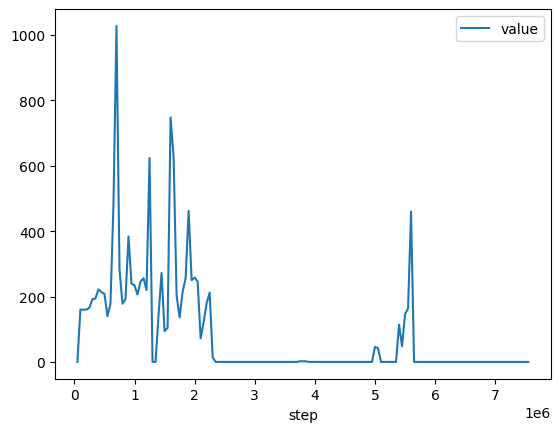

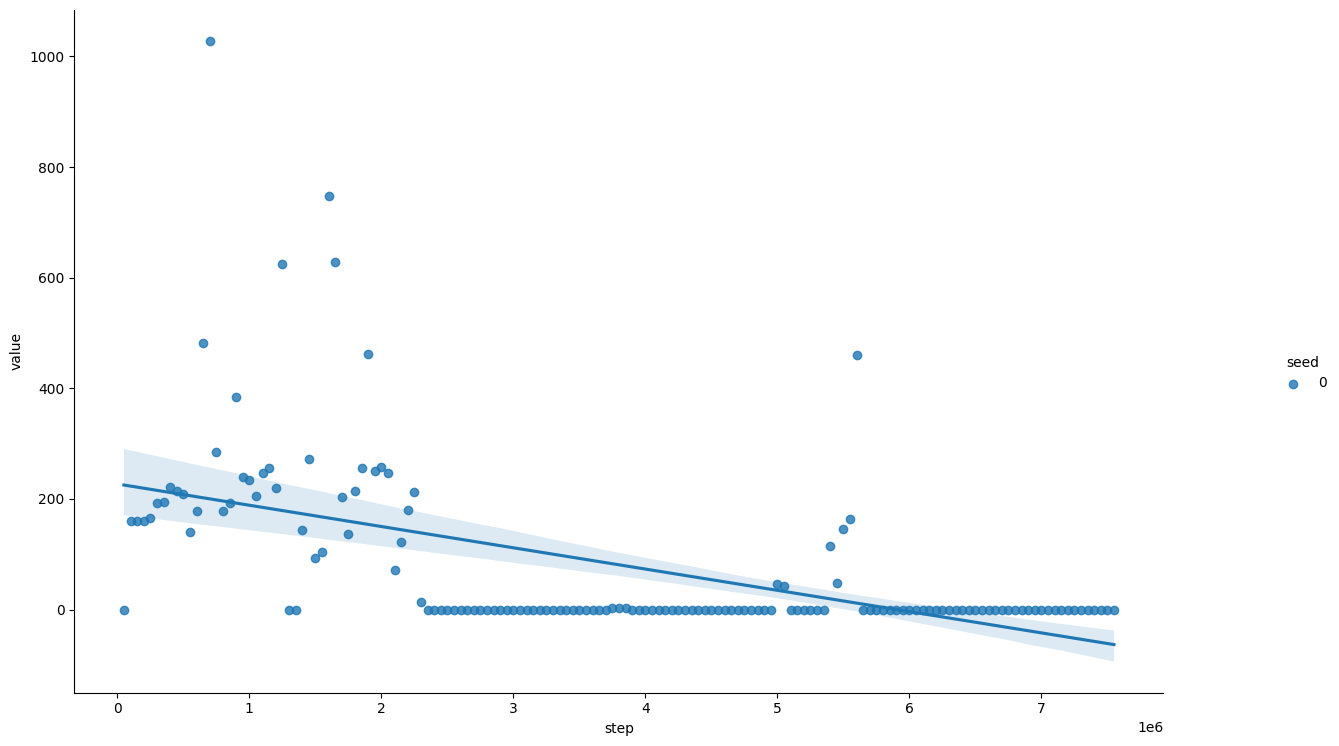

Dataframes:


,wall_time,step,value,seed
0,1.711732e+09,50000,0.0,0
1,1.711732e+09,100000,160.0,0
2,1.711732e+09,150000,160.0,0
3,1.711732e+09,200000,160.0,0
4,1.711732e+09,250000,166.0,0
...,...,...,...,...
146,1.711796e+09,7350000,0.0,0
147,1.711797e+09,7400000,0.0,0
148,1.711797e+09,7450000,0.0,0
149,1.711797e+09,7500000,0.0,0


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


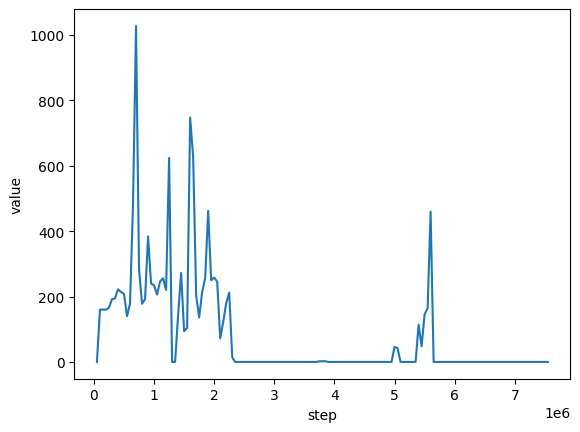

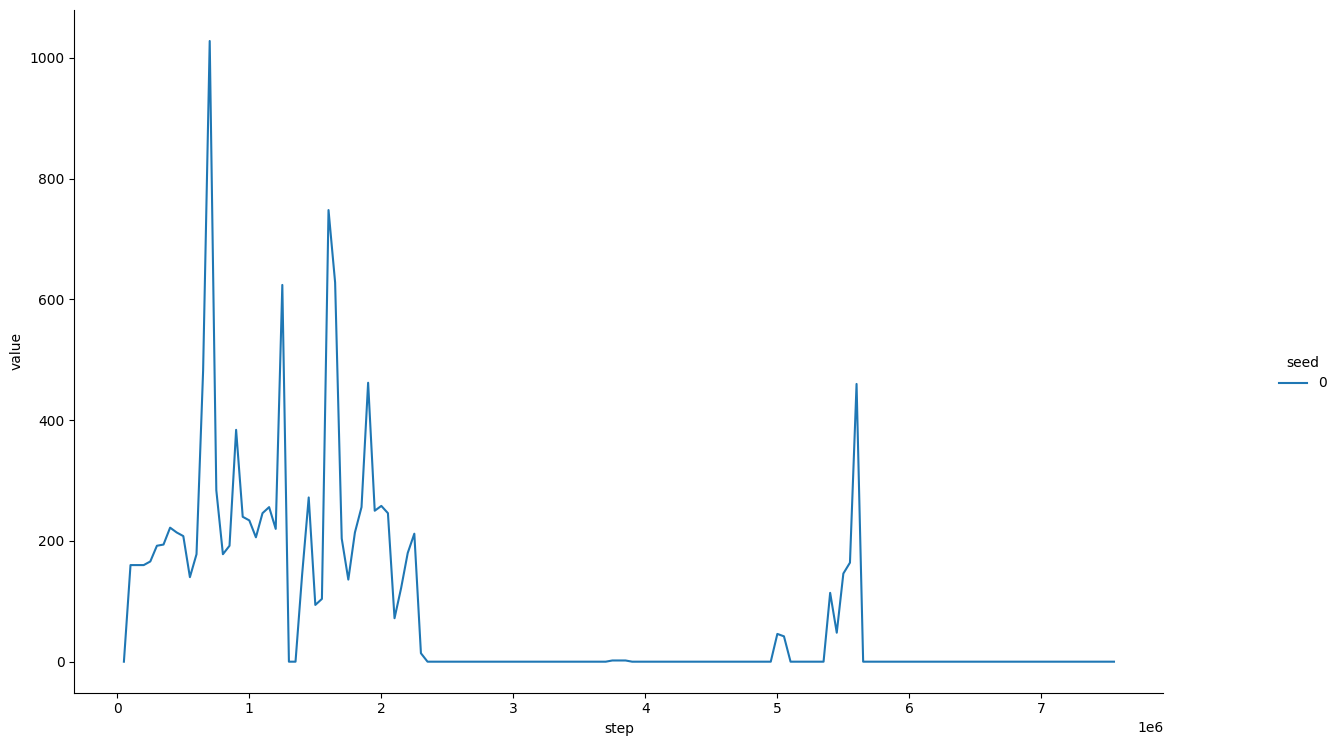

In [11]:
from packaging import version

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import tensorflow as tf

major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
    "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

print("TensorFlow version: ", tf.__version__)

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing import event_accumulator

def get_event_accumulator(path):
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0,
                       event_accumulator.TENSORS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    return ea

def print_tensorboard_log_summary(path):
    return get_event_accumulator(path).Tags()

def parse_tensorboard_tensors(path, tensors):
    """returns a dictionary of pandas dataframes for each requested tensors"""
    ea = get_event_accumulator(path)
    # make sure the tensors are in the event accumulator tags
    assert all(
        s in ea.Tags()["tensors"] for s in tensors
    ), "some tensors were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Tensors(k)) for k in tensors}

def parse_tensorboard_scalars(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = ea = get_event_accumulator(path)
    # make sure the scalars are in the event accumulator tags
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), "some scalars were not found in the event accumulator"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

experiment_log = f"{tensorflow_path}{file_name}/initial_0_20000000_1"
display(print_tensorboard_log_summary(experiment_log))

ea = get_event_accumulator(experiment_log)
scalars = ea.Scalars('eval/mean_reward')
print(scalars)
df3 = parse_tensorboard_scalars(experiment_log, ['eval/mean_reward']) #, 'eval/mean_ep_length', 'time/fps', 'rollout/ep_rew_mean', 'train/value_loss'
display(df3)

display(df3["eval/mean_reward"].mean())
import pandas as pd
import matplotlib.pyplot as plt

df3["eval/mean_reward"].plot(x = 'step', y = 'value')

plt.show()

mean_reward = df3["eval/mean_reward"]

# mean_reward_seed_3['seed'] = hyperparameters['seed']
mean_reward['seed'] = 0

combined_reward = pd.concat([mean_reward], axis = 1)

g = sns.lmplot(x="step", y="value", hue="seed",
               data=pd.concat([mean_reward]), fit_reg=True)
g.fig.set_size_inches(15, 8)
plt.show()

print('Dataframes:')
display(mean_reward)

g = sns.lineplot(x="step", y="value", err_style="bars", errorbar=("se", 2), data=mean_reward) # , hue="seed", style="seed"
plt.show()

ng = sns.relplot(x="step", y="value", hue="seed", kind="line", style="seed", data=mean_reward)
ng.fig.set_size_inches(15, 8)
plt.show()